# Data handling

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import os

# Configure plotting style
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

# Load and merge data from multiple sites
def load_and_merge_data(folder, site_names):
    dfs = []
    for site in site_names:
        file_path = f"{folder}PRSA_Data_{site}_20130301-20170228.csv"
        df = pd.read_csv(file_path)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)


def save_merged_data(data, file_path):
    try:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        data.to_csv(file_path)
        print(f"Data successfully saved to {file_path}")
    except Exception as e:
        print(f"Error saving data: {e}")

# Selected sites
selected_sites = ["Aotizhongxin", "Changping", "Dingling", "Dongsi", "Guanyuan"]
data_folder = "PRSA_Data_20130301-20170228/"

# Execute data loading
data = load_and_merge_data(data_folder, selected_sites)

# EDA

## Data understanding

In [14]:
print("\n=== Data Overview ===")
print(f"Shape: {data.shape}")
print("\nData Types:")
data.dtypes
print("\nMissing Values (%):")
(data.isnull().sum()/len(data)*100).round(2)


=== Data Overview ===
Shape: (175320, 18)

Data Types:

Missing Values (%):


No         0.00
year       0.00
month      0.00
day        0.00
hour       0.00
PM2.5      2.19
PM10       1.68
SO2        1.96
NO2        2.96
CO         5.85
O3         3.07
TEMP       0.09
PRES       0.09
DEWP       0.09
RAIN       0.09
wd         0.30
WSPM       0.07
station    0.00
dtype: float64

In [15]:
# Statistical summary
print("\n=== Statistical Summary ===")
print(data.describe().transpose())


=== Statistical Summary ===
          count          mean           std        min      25%      50%  \
No     175320.0  17532.500000  10122.133783     1.0000  8766.75  17532.5   
year   175320.0   2014.662560      1.177200  2013.0000  2014.00   2015.0   
month  175320.0      6.522930      3.448713     1.0000     4.00      7.0   
day    175320.0     15.729637      8.800117     1.0000     8.00     16.0   
hour   175320.0     11.500000      6.922206     0.0000     5.75     11.5   
PM2.5  171476.0     77.799974     79.436749     2.0000    19.00     53.0   
PM10   172382.0    101.572651     90.510711     2.0000    34.00     78.0   
SO2    171890.0     16.042345     21.511385     0.2856     3.00      8.0   
NO2    170136.0     48.554262     34.701323     1.0265    22.00     41.0   
CO     165061.0   1183.408479   1132.271056   100.0000   500.00    800.0   
O3     169946.0     59.166284     56.516353     0.2142    14.00     48.0   
TEMP   175154.0     13.642569     11.397480   -16.8000     

In [16]:
data.describe(include='object')

,wd,station
count,174800,175320
unique,16,5
top,NE,Aotizhongxin
freq,17262,35064


## Feature engineering

In [29]:
data.columns

Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'WSPM', 'station', 'wind_ENE', 'wind_ESE', 'wind_N', 'wind_NE',
       'wind_NNE', 'wind_NNW', 'wind_NW', 'wind_S', 'wind_SE', 'wind_SSE',
       'wind_SSW', 'wind_SW', 'wind_W', 'wind_WNW', 'wind_WSW'],
      dtype='object')

In [17]:
# Handle missing values
data.fillna(method='ffill', inplace=True)  # Forward fill for time-series
data.dropna(inplace=True)  # Remove remaining missing values

# Remove duplicates
print(f"\nInitial duplicates: {data.duplicated().sum()}")
data.drop_duplicates(inplace=True)

# Feature engineering
data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
data.set_index('datetime', inplace=True)
data.drop(columns=['No', 'year', 'month', 'day', 'hour'], inplace=True)

# Encode categorical variables
data = pd.get_dummies(data, columns=['wd'], prefix='wind', drop_first=True)
le = LabelEncoder()
data['station'] = le.fit_transform(data['station'])

# Handle outliers (IQR method)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]

data = remove_outliers(data, 'PM2.5')

C:\Users\sutir\AppData\Local\Temp\ipykernel_24964\3626633084.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill for time-series



Initial duplicates: 0


In [19]:
# Save the data for GUI app development
save_merged_data(data, "./merged_air_quality.csv")

Data successfully saved to ./merged_air_quality.csv


## Data Visualisation

### Univariate

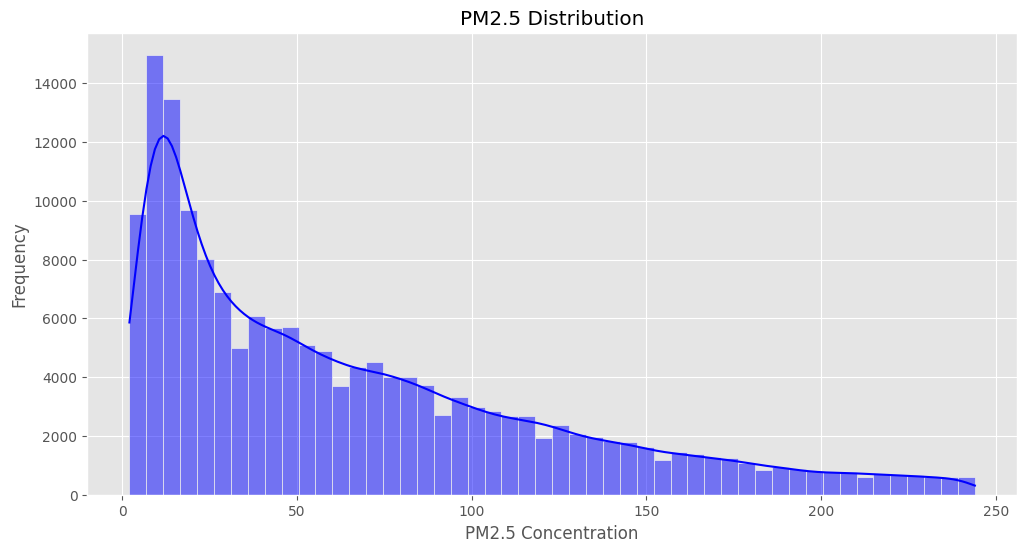

In [26]:
# Univariate analysis
plt.figure(figsize=(12, 6))
sns.histplot(data['PM2.5'], color='blue', bins=50, kde=True)
plt.title('PM2.5 Distribution')
plt.xlabel('PM2.5 Concentration')
plt.ylabel('Frequency')
plt.show()

C:\Users\sutir\AppData\Local\Temp\ipykernel_24964\1381491562.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data['PM2.5'].resample('M').mean().plot()


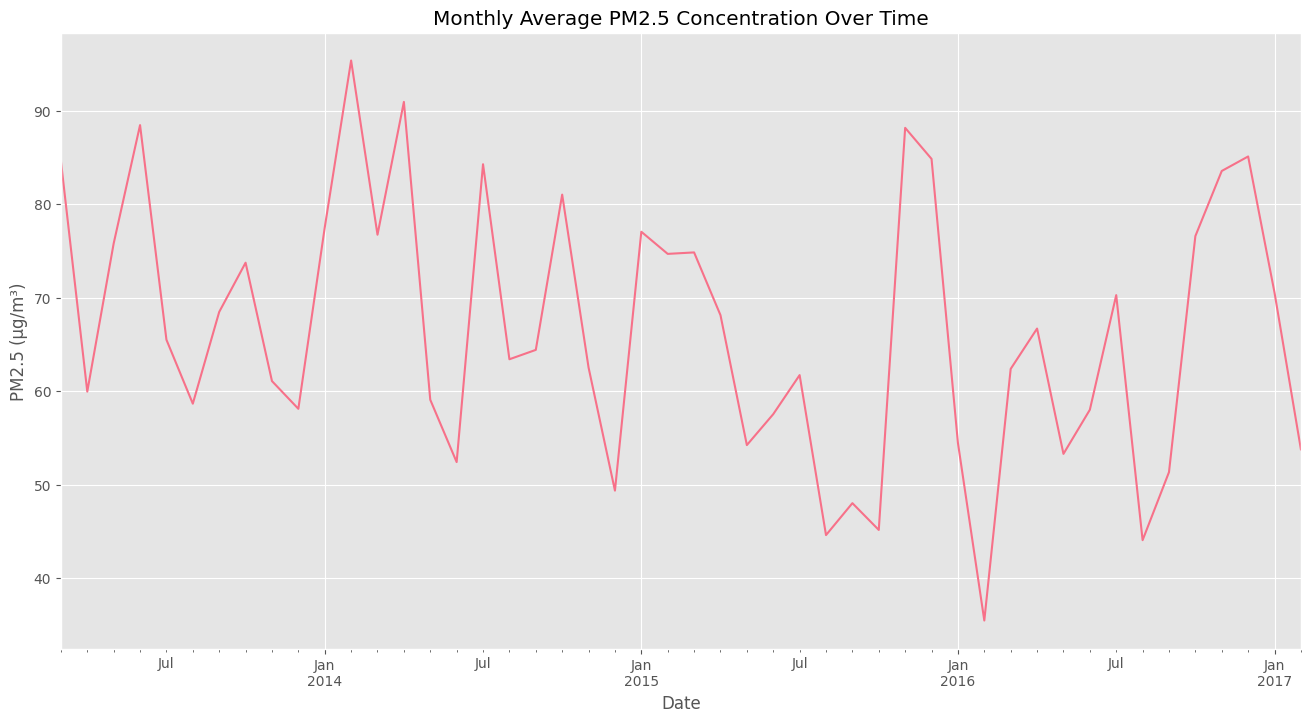

In [28]:
# Time series analysis
plt.figure(figsize=(16, 8))
data['PM2.5'].resample('M').mean().plot()
plt.title('Monthly Average PM2.5 Concentration Over Time')
plt.ylabel('PM2.5 (µg/m³)')
plt.xlabel('Date')
plt.show()

### Bivariate

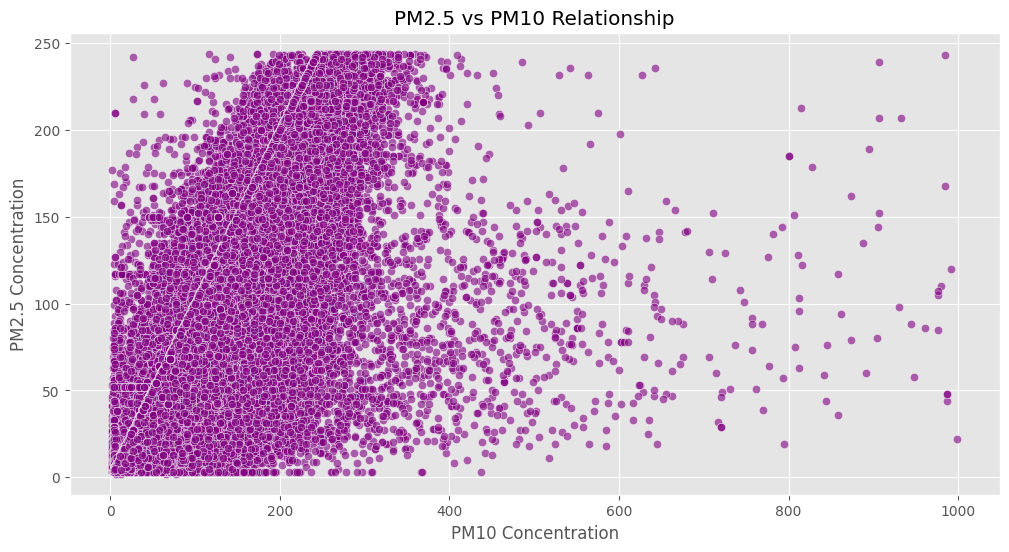

In [24]:
# Bivariate analysis
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PM10', y='PM2.5', c='purple', data=data, alpha=0.6)
plt.title('PM2.5 vs PM10 Relationship')
plt.xlabel('PM10 Concentration')
plt.ylabel('PM2.5 Concentration')
plt.show()

### Multivariate

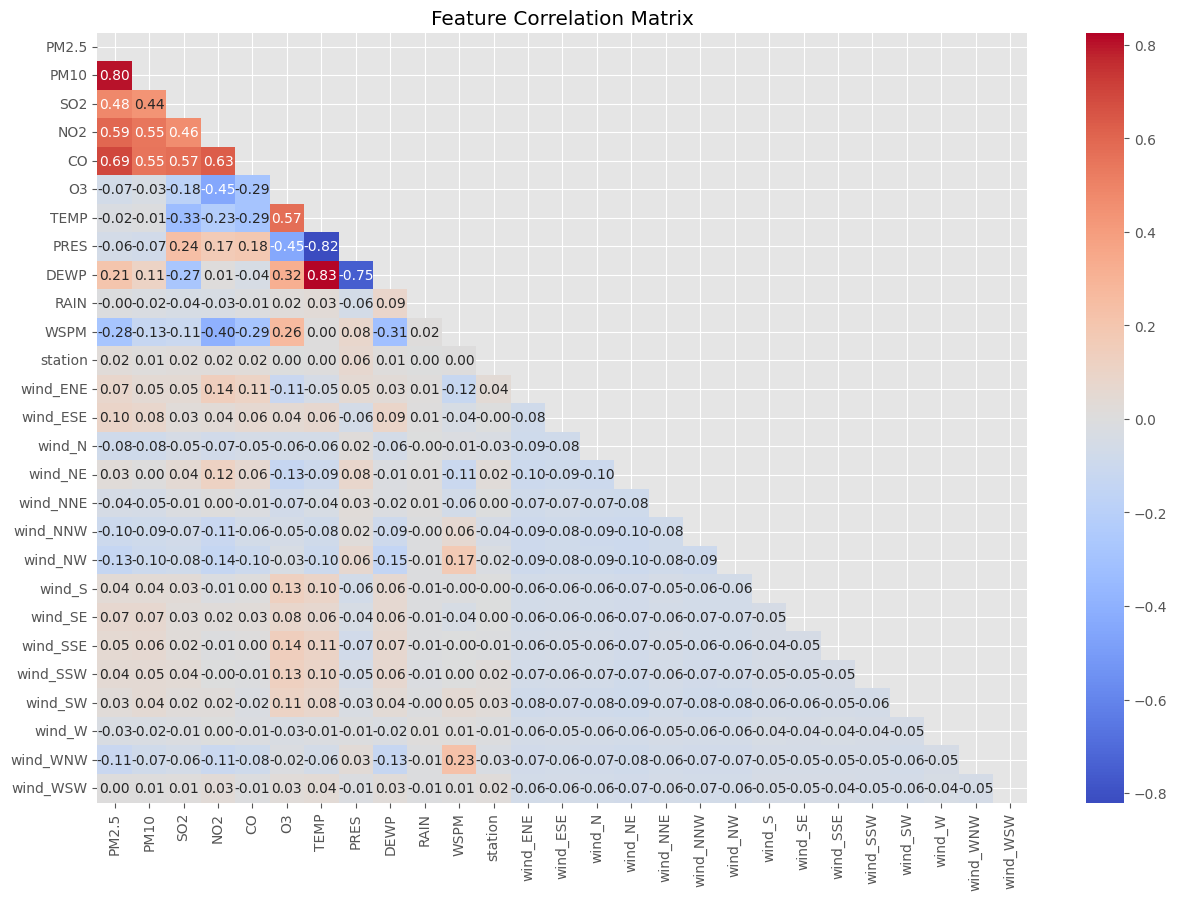

In [27]:
# Correlation matrix
plt.figure(figsize=(15, 10))
corr_matrix = data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

# Model 